I donwloaded recent water level observations from this website.
http://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07795

For comparison with nowcast or nowcast-green in September 2016

In [1]:
import pandas as pd
from dateutil import tz
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

from nowcast.figures import shared, figures
from nowcast import analyze
%matplotlib inline

In [2]:
def dateparse(s):
    """Function to make datetime object aware of time zone
    e.g. date_parser=dateParserMeasured('2014-05-31 11:42')

    :arg s: string of date and time
    :type s: str

    :returns: datetime object that is timezone aware
    """
    PST_tz = tz.tzoffset("PST", -28800)
    # Convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M")
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST_tz)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [3]:
data = pd.read_csv('Sep10-28VI.csv',parse_dates=[1],date_parser=dateparse)
data=data.rename(columns={'TIME_TAG PST (Z+8)': 'time'})
series = pd.Series(np.array(data['ENCODER2']), index = data['time'])
tidesDFO = pd.Series(np.array(data['PREDICTION']), index = data['time'])
series=series.resample('15T').mean()
tidesDFO=tidesDFO.resample('15T').mean()

In [4]:
def load_model_ssh(grid):
    ssh = grid.variables['sossheig'][:, 0, 0]
    time = grid.variables['time_counter']
    dates=nc.num2date(time[:], time.units)
    return ssh, dates

In [5]:
nowcast = '/results/SalishSea/nowcast/'
nowcast_green = '/results/SalishSea/nowcast-green/'
location = 'Victoria'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
sdt = datetime.datetime(2016,9,11)
edt = datetime.datetime(2016,9,26)

labels={nowcast: 'nowcast', nowcast_green: 'nowcast-green'}

numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

ssh = {}
time = {}
ssh_corr={}
runs = [nowcast, nowcast_green]
tides = shared.get_tides('Victoria',path=tides_path)
for run in runs:
    ssh[run] = np.array([])
    time[run] = np.array([])
    for d in dates:
        fname = os.path.join(run, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
        grid = nc.Dataset(fname)
        s,t = load_model_ssh(grid)
        ssh[run]=np.append(ssh[run],s)
        time[run]=np.append(time[run],t)
    time[run] = np.array([da.replace(tzinfo=tz.tzutc()) for da in time[run]])
    ssh_corr[run] = shared.correct_model_ssh(ssh[run], time[run],tides )

# Interpolate observations to model times

In [6]:
obs_interp={}
for run in runs:
    obs_interp[run] = shared.interp_to_model_time(time[run], series, series.index)
    obs_interp[run] = np.array(obs_interp[run]) - figures.SITES[location]['msl']

# Our tides and DFO tides
DFO stores tides online. How do their tides compare with the tides I calculated with ttide?

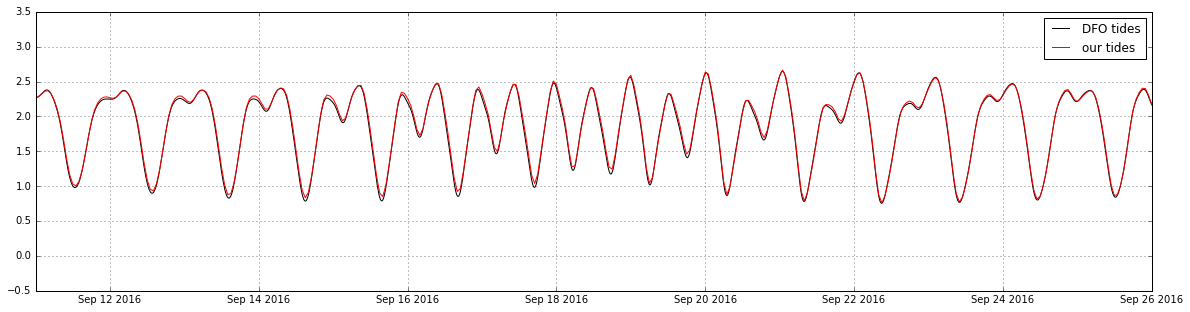

In [7]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(tidesDFO.index, tidesDFO,  'k',label='DFO tides')
ax.plot(tides.time, tides.pred_all+figures.SITES['Victoria']['msl'] , 'r', label='our tides')
ax.set_xlim([sdt,edt])
ax.legend()
ax.grid()

Differences between my tidal predictions and DFOs -- why? I'm using their constituents and looped through year by year in t_tide to update nodal corrections...

# Compare water levels - observed, nowcast, nowcast-green

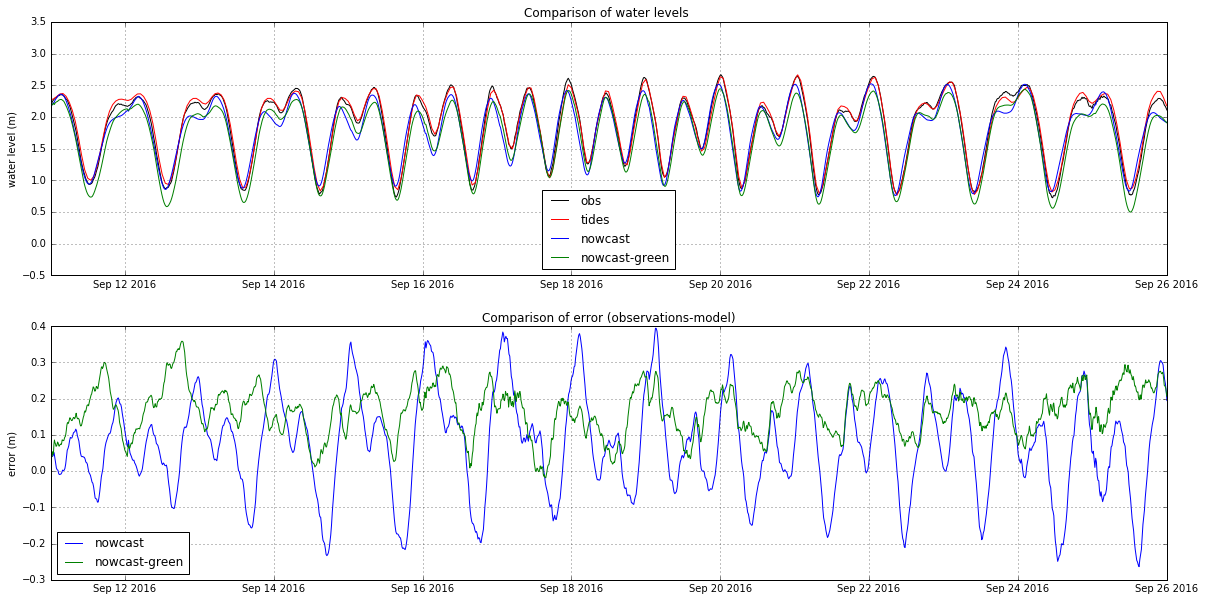

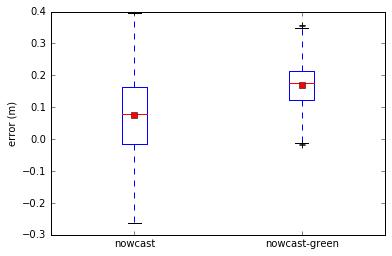

In [8]:
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(series.index, series, 'k',label='obs')
ax.plot(tides.time, tides.pred_all +figures.SITES['Victoria']['msl'], 'r', label='tides')
for run in runs:
    ax.plot(time[run],ssh[run]+figures.SITES['Victoria']['msl'], label=labels[run])
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])
ax.set_title('Comparison of water levels ')

#error
errors={}
ax=axs[1]
for run in runs:
    errors[run] = obs_interp[run]-ssh[run]
    errors[run] = errors[run][~np.isnan(errors[run])]
    ax.plot(time[run],obs_interp[run]-ssh[run], label=labels[run])

ax.set_ylabel('error (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])
ax.set_title('Comparison of error (observations-model)')

fig,ax=plt.subplots(1,1)
ax.boxplot([errors[nowcast], errors[nowcast_green]],showmeans=True)
ax.set_xticklabels([labels[nowcast],labels[nowcast_green]])
ax.set_ylabel('error (m)')

# Corrected water levels

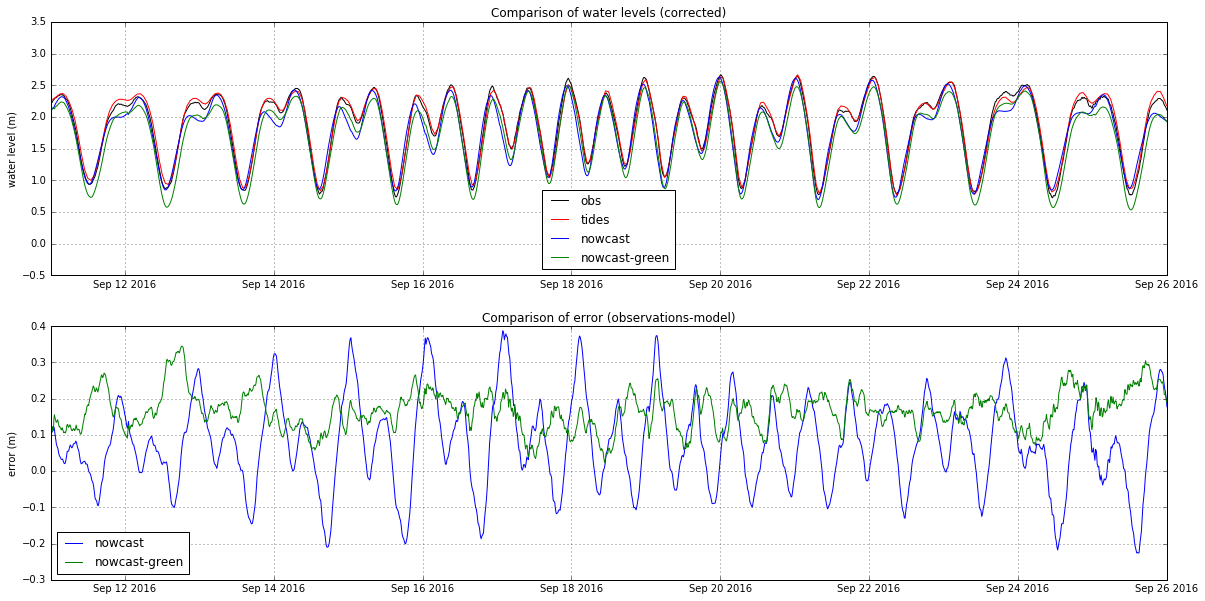

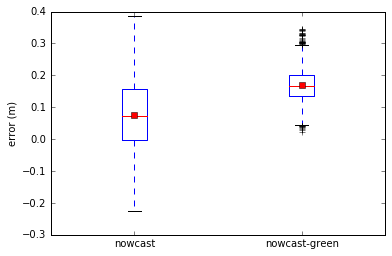

In [9]:
fig,axs=plt.subplots(2,1,figsize=(20,10))
ax=axs[0]
ax.plot(series.index, series, 'k',label='obs')
ax.plot(tides.time, tides.pred_all +figures.SITES['Victoria']['msl'], 'r', label='tides')
for run in runs:
    ax.plot(time[run],ssh_corr[run]+figures.SITES['Victoria']['msl'], label=labels[run])
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt, edt])
ax.set_title('Comparison of water levels (corrected)')

#error
errors={}
ax=axs[1]
for run in runs:
    errors[run] = obs_interp[run]-ssh_corr[run]
    errors[run] = errors[run][~np.isnan(errors[run])]
    ax.plot(time[run],obs_interp[run]-ssh_corr[run], label=labels[run])

ax.set_ylabel('error (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt, edt])
ax.set_title('Comparison of error (observations-model)')

fig,ax=plt.subplots(1,1)
ax.boxplot([errors[nowcast], errors[nowcast_green]],showmeans=True)
ax.set_xticklabels([labels[nowcast],labels[nowcast_green]])
ax.set_ylabel('error (m)')



### Spectrum of error

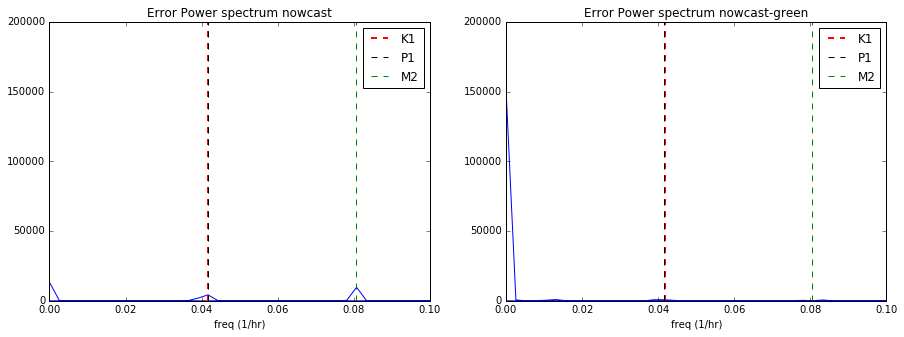

In [10]:
M2_freq=28.984106/360
K1_freq = 15.041069000/360
P1_freq = 14.9589314/360
fig,axs=plt.subplots(1,2,figsize=(15,5))
for ax, run in zip(axs,runs):
    if run == nowcast:
        freq=1/4
    else:
        freq=1/6
    ps = np.abs(np.fft.fft((errors[run])))**2
    freqs = np.fft.fftfreq(errors[run].size, freq)
    ax.plot(freqs,ps)
    ax.set_ylim([0,2*10**5])
    ax.set_xlim([0,.1])
    ax.set_xlabel('freq (1/hr)')
    ax.set_title('Error Power spectrum {}'.format(labels[run]))
    ax.plot([K1_freq,K1_freq],[0,2*10**5],'r--',label='K1',lw=2)
    ax.plot([P1_freq,P1_freq],[0,2*10**5],'k--',label='P1')
    ax.plot([M2_freq,M2_freq],[0,2*10**5],'g--',label='M2')
    ax.legend()

# Residuals

In [11]:
model_res={}
obs_res={}
for run in runs:
    tides_interp = shared.interp_to_model_time(time[run], tides.pred_all, tides.time)
    model_res[run] = ssh_corr[run] - tides_interp
    obs_res[run] = obs_interp[run] - tides_interp

(-0.4, 0.4)

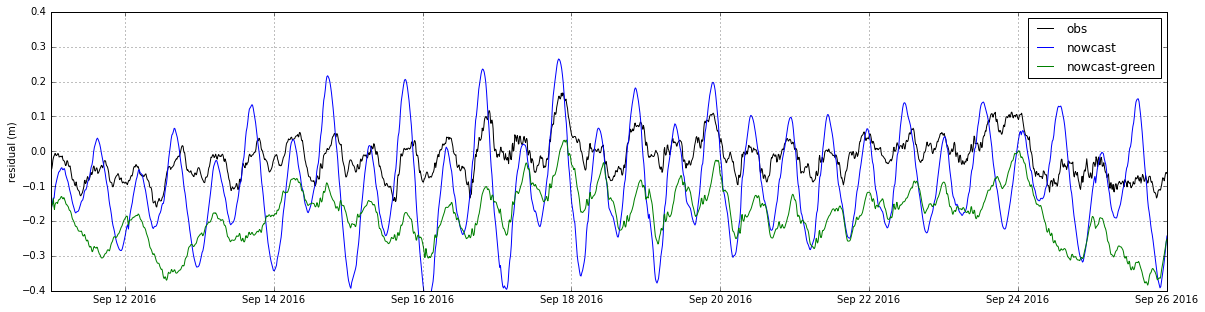

In [12]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(time[run], obs_res[run], 'k',label='obs')
for run in runs:
    ax.plot(time[run], model_res[run], label=labels[run])
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()
ax.set_xlim([sdt,edt])
ax.set_ylim([-.4,.4])

* Not happy about the residual caluclation. There looks to be some tidal energy in the all of the residuals. Have I interpolated in time correctly? Can I improve my tidal predictions?
* My predictions are hourly, where as DFO are every 5 minutes and model outputs are every 15 minutes. Everything is interpolated to model times.


# Residuals with DFO tides

In [13]:
model_res={}
obs_res={}
for run in runs:
    tides_interp = shared.interp_to_model_time(time[run], tidesDFO -figures.SITES['Victoria']['msl'], tidesDFO.index)
    model_res[run] = ssh_corr[run] - tides_interp
    obs_res[run] = obs_interp[run] - tides_interp

(-0.4, 0.4)

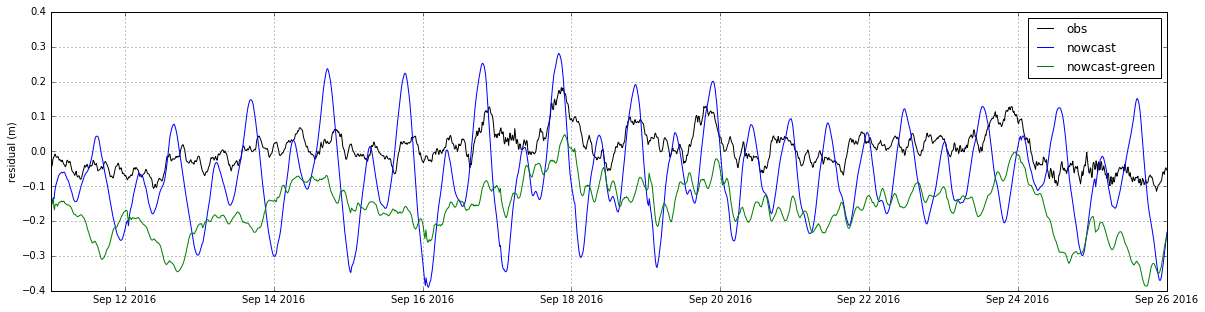

In [14]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(time[run], obs_res[run], 'k',label='obs')
for run in runs:
    ax.plot(time[run], model_res[run], label=labels[run])
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()
ax.set_xlim([sdt, edt])
ax.set_ylim([-.4,.4])

* Ok, so if we use our tidal predictions then we have semi-dirunal tidal energy in the observed residuals but the nowcast-green is ok. But if we use DFO tidal predictions, the nowcast-green resdiual has semi-diurnal energy but observed residuals are ok. Weird! Is the a discrepancy in between our harmonics and the ones used in the DFO tidal predictions?

### Daily mean residual

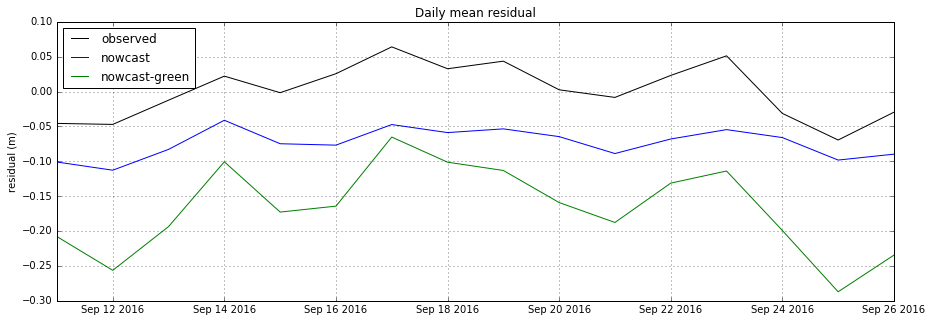

In [15]:
green=pd.DataFrame(data=model_res[nowcast_green], index=time[nowcast_green])
green = green.resample('1d').mean()

now=pd.DataFrame(data=model_res[nowcast], index=time[nowcast])
now = now.resample('1d').mean()

obs_data = pd.DataFrame(data=obs_res[nowcast], index=time[nowcast])
obs_data = obs_data.resample('1d').mean()

fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(obs_data.index, obs_data, 'k',label='observed')
ax.plot(now.index, now,label='nowcast')
ax.plot(green.index, green,label='nowcast-green')
ax.legend(loc=0)
ax.grid()
ax.set_ylabel('residual (m)')
ax.set_title('Daily mean residual')

# Summary

In [16]:
for run in runs:
    print('{} - Mean water level error: {} m'.format(labels[run], errors[run].mean()))

nowcast - Mean water level error: 0.07490642388105716 m
nowcast-green - Mean water level error: 0.16921076180221797 m


* Nowcast-green shows improvement over nowcast. Particularyl, the strong diurnal signal in the nowcast residual is not present in nowcast-green.
* But, I'm concerned about our tidal predictions and would like to investigate that further. 

In [17]:
for run in runs:
    print('{} Mean water level: {} m'.format(labels[run], ssh[run].mean()))

nowcast Mean water level: -0.0951257441935572 m
nowcast-green Mean water level: -0.18942778417876127 m
